# <span id="toc">  Esercizio 8 - Simulated Annealing </span>

- [Esercizio 8.1](#ex08_1)

- [Esercizio 8.2](#ex08_2)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Il principio variazionale della meccanica quantistica afferma che il valore atteso 
dell’Hamiltoniana calcolato su uno stato di prova fornisce un limite inferiore 
all’energia dello stato fondamentale $E_0$:

$$
\langle \hat{H} \rangle_T = 
\frac{\int dx \, \Psi_T^*(x) \hat{H} \Psi_T(x)}{\int dx \, |\Psi_T(x)|^2}
\;\; \geq \;\;
E_0 = \frac{\langle \Psi_0 | \hat{H} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}
$$

In questo esercizio voglio ottimizzare variazionalmente lo stato fondamentale di una particella in una dimensione, confinata da un potenziale esterno del tipo:

$$
V(x) = x^4 - \frac{5}{2} x^2.
$$

Questo modello quantistico 1D non è risolvibile analiticamente, si utilizza 
il metodo **Variational Monte Carlo (VMC)**, basato su una funzione d’onda di prova parametrizzata da 
alcuni parametri variazionali, ad esempio:

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

che dipende dai due parametri variazionali $\sigma$ e $\mu$.


## <span id="ex08_1">  Esercizio 8.1 </span>[^](#toc)

In questo esercizio uso lo stesso algoritmo di Metropolis dell'Esercizio 5 per campionare la densità di probabilità della funzione d'onda di prova $|\Psi_T^{\sigma,\mu}(x)|^2$ usando probabilità di transizione uniforme $T(x|y)$. 

Data una certa coppia di valori ragionevoli per $\mu$ e $\sigma$, l'obiettivo è calcolare il valore di aspettazione dell'Hamiltoniana:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} 
$$

(con $\hbar = 1$ and $m=1$) che servirà per trovare i valori ottimali di  $\mu_{best}$ e $\sigma_{best}$ che minimizza questa quantità.

In particolare è necessario calcolare per ogni blocco il valore medio di:

$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$

Per questa prima stima dell'energia, ho scelto come valori iniziali $\mu=1$, $\sigma=0.5$. 

Anche in questo esercizio è necessario innanzitutto equilibrare il sistema, per farlo ho impostato i seguenti parametri iniziali: 

```
500  blocchi
1    step per blocco
1.2  larghezza passo 
0    pos iniziale
```

Successivamente ho eseguito la simulazione vera e propria ripartendo dalle posizioni finali ottenute durante la fase di equilibrazione e impostando i parametri:

```
100  blocchi
100  step per blocco
1.2  larghezza passo 
```

così da ottenere un'accettazione del $0.4993$.

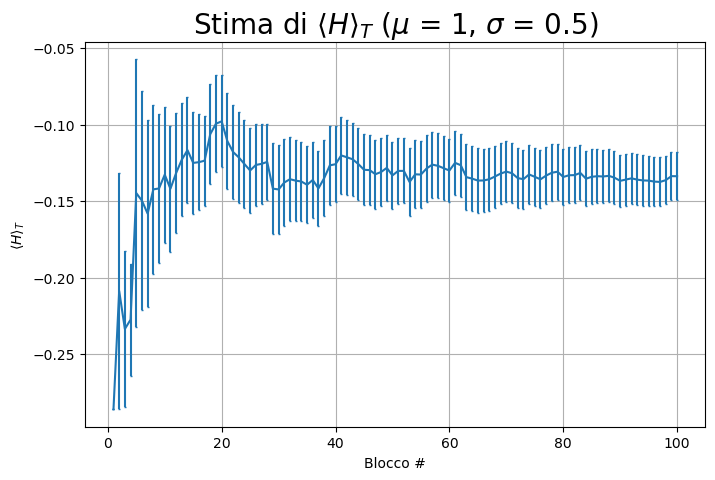

Valore medio finale di <H> =  -0.133627
Incertezza =  0.0157498


In [2]:
# Stima iniziale di H
plt.figure(figsize=(8,5))

block, H, err_H = np.loadtxt('OUTPUT/energy/H/energy.dat', skiprows=1, usecols=(0,2,3), unpack=True)

plt.errorbar(block, H, yerr=err_H, capsize=1)
plt.xlabel('Blocco #', fontsize=10)
plt.ylabel(r'$\langle H \rangle_{T}$', fontsize=10)
plt.title(r'Stima di $\langle H \rangle_{T}$ ($\mu$ = 1, $\sigma$ = 0.5)', fontsize=20)
plt.grid(True)

plt.show()

print('Valore medio finale di <H> = ', H[-1])
print('Incertezza = ', err_H[-1])

## <span id="ex08_2">  Esercizio 8.2 </span>[^](#toc)

In questo esercizio, per riuscire a minimizzare l'energia ho implementato il **Simulated Annealing (SA)**, ovvero un metodo di ottimizzazione che consiste nell’associare a un insieme di parametri una "mobilità", quantificata attraverso una temperatura fittizia.  

Il sistema viene fatto evolvere gradualmente riducendo la temperatura: in questo modo i parametri 
possono esplorare diverse configurazioni, evitando di rimanere intrappolati in minimi locali, 
fino a stabilizzarsi in un minimo dell’energia. L’obiettivo è calibrare la simulazione affinché il minimo trovato sia il più possibile vicino al 
minimo globale.  

In questo caso la temperatura regola la mobilità dei parametri variazionali $\mu$ e $\sigma$, 
che vengono aggiornati tramite il metodo di Metropolis durante la procedura di annealing, fino a convergere verso i valori ottimali che minimizzano l’energia variazionale.

### Simulated Annealing

Ho fissato la temperatura di partenza a $T=1$ corrispondente $\beta=1/T$, successivamente ho fatto crescere progressivamente il valore di $\beta$ con passo $\Delta\beta$, in modo da ridurre la mobilità dei parametri e 
“raffreddare” il sistema.  

Ad ogni valore di $\beta$ ho eseguito $50$ passi di ottimizzazione, in cui vengono proposte 
piccole variazioni di $\mu$ e $\sigma$ all'interno un intervallo $[-\Delta, \Delta]$. Le nuove configurazioni vengono accettate secondo la 
probabilità di Metropolis:  

$$
A = \min \left[1, e^{\beta (H_{\text{old}} - H_{\text{new}})} \right]
$$

dove $H_{\text{old}}$ e $H_{\text{new}}$ sono le stime variazionali dell’energia.  

Il processo di annealing prosegue fino a quando l’ampiezza effettiva delle variazioni $2\Delta/\beta$ diventa comparabile con la precisione desiderata sui parametri, fissata a $\epsilon_\mu$ e $\epsilon_\sigma$.  

Alla fine della procedura, ottengo i valori $\mu_{best}$ e $\sigma_{best}$ che minimizzano 
l’energia variazionale.

I parametri iniziali scelti per questa serie di simulazioni sono:

```
1     delta_beta
1     delta_mu
1     delta_sigma
0.01  err_mu
0.01  err_sigma
```

Al termine della procedura di Simulated Annealing ho ottenuto i seguenti valori:  

- $\langle \hat{H} \rangle_T = -0.458366$  
- $\mu_{best} = -0.789$  
- $\sigma_{best} = -0.638$  

Di seguito riporto l'andamento di $\langle \hat{H} \rangle_T$ in funzione di $\beta$.

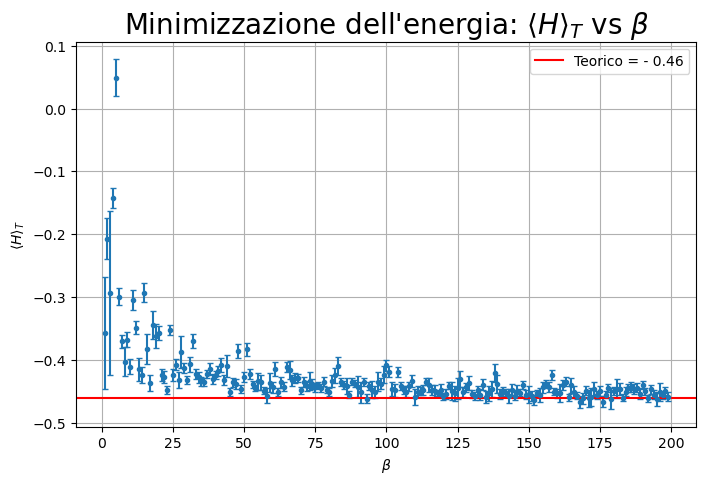

Valore minimo di <H> ottenuto con SA =  -0.458366
Incertezza =  0.00730794


In [3]:
# Simulated Annealing
plt.figure(figsize=(8,5))

step, beta, H_SA, err_H_SA = np.loadtxt('OUTPUT/annealing/annealing.dat', skiprows=1, usecols=(0,1,4,5), unpack=True)

steps_beta = 50
mask = (step == steps_beta) 
beta = beta[mask]
H_SA = H_SA[mask]
err_H_SA = err_H_SA[mask]

plt.errorbar(beta, H_SA, yerr=err_H_SA, fmt='.', capsize=2, linestyle='')
plt.axhline(y=-0.46, color='r', linestyle='-', label='Teorico = - 0.46')
plt.xlabel(r'$\beta$', fontsize=10)
plt.ylabel(r'$\langle H \rangle_{T}$', fontsize=10)
plt.title(r"Minimizzazione dell'energia: $\langle H \rangle_{T}$ vs $\beta$", fontsize=20)
plt.legend()
plt.grid()

plt.show()

print('Valore minimo di <H> ottenuto con SA = ', H_SA[-1])
print('Incertezza = ', err_H_SA[-1])

Nel grafico è rappresenta la configurazione finale verso cui il sistema converge, cioè la migliore approssimazione 
trovata per lo stato fondamentale con la funzione d’onda scelta. 

L’energia di questo stato può essere confrontata con il valore numerico di riferimento ottenuto dalla diagonalizzazione 
dell’Hamiltoniana, ovvero $E_0 \approx -0.46$, e si osserva che il risultato trovato è compatibile con questo valore.

Riporto anche la traiettoria descritta dalle stime di $\langle \hat{H} \rangle_T$ durante il SA nello spazio $(\mu$, $\sigma)$ al variare di ogni step.

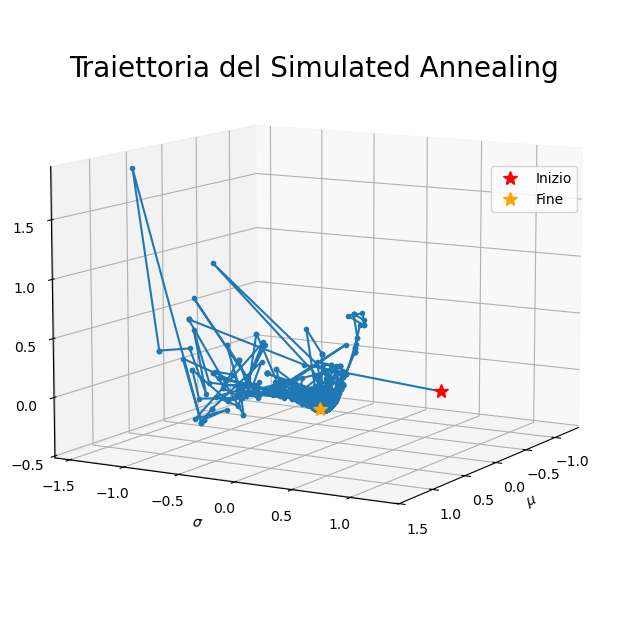

Parametro mu ottimale =  -0.788637
Parametro sigma ottimale =  -0.637786


In [4]:
# Traiettoria SA
fig = plt.figure(figsize=(6,6))

mu, sigma, H_SA = np.loadtxt('OUTPUT/annealing/annealing.dat', skiprows=1, usecols=(2,3,4), unpack=True)

ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(mu, sigma, H_SA, marker='.')
ax.plot(mu[0], sigma[0], H_SA[0], color="red", marker='*', markersize=10, linestyle='', label='Inizio')
ax.plot(mu[-1], sigma[-1], H_SA[-1], color="orange", marker='*', markersize=10, linestyle='', label='Fine')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel(r'$\langle H \rangle_{T}$')
ax.set_title('Traiettoria del Simulated Annealing', fontsize=20, y=0.95)
ax.view_init(10, 30)
ax.legend(bbox_to_anchor=(0.95, 0.75))

plt.show()

print('Parametro mu ottimale = ', mu[-1])
print('Parametro sigma ottimale = ', sigma[-1])

### Energia minima

A questo punto ho ripetuto un'ultima volta l'algoritmo di Metropolis per stimare nuovamente il valore di $\langle \hat{H} \rangle_T$, questa volta però utilizzando i valori di $\mu_{best} = -0.789$ e $\sigma_{best} = -0.638$ trovati durante il SA.

Questa procedura fornisce la stima finale dell’energia minima raggiungibile con la funzione d’onda scelta.

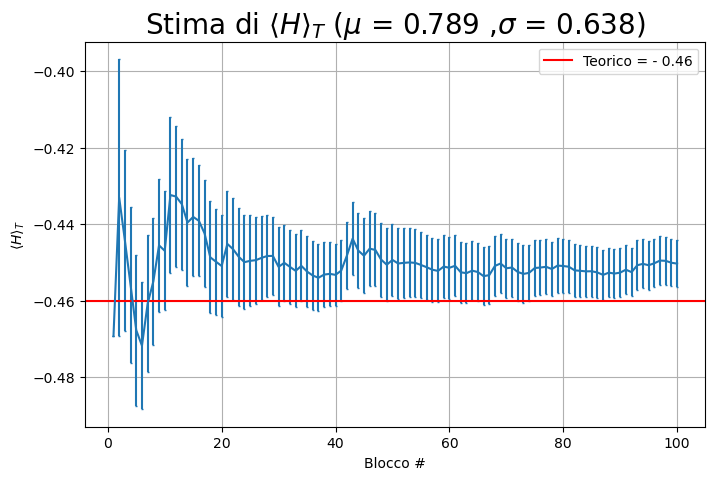

Valore medio finale di <H> =  -0.450309
Incertezza =  0.00613606


In [5]:
# Stima H minima
plt.figure(figsize=(8,5))

block, H_best, err_H_best = np.loadtxt('OUTPUT/energy/H_best/energy.dat', skiprows=1, usecols=(0,2,3), unpack=True)

plt.errorbar(block, H_best, yerr=err_H_best, capsize=1)
plt.axhline(y=-0.46, color='r', linestyle='-', label='Teorico = - 0.46')
plt.xlabel('Blocco #', fontsize=10)
plt.ylabel(r'$\langle H \rangle_{T}$', fontsize=10)
plt.title(r'Stima di $\langle H \rangle_{T}$ ($\mu$ = 0.789 ,$\sigma$ = 0.638)', fontsize=20)
plt.legend()
plt.grid(True)

plt.show()

print('Valore medio finale di <H> = ', H_best[-1])
print('Incertezza = ', err_H_best[-1])

Dal grafico si osserva che il risultato ottenuto è leggermente più alto del valore minimo atteso, ma è comunque compatibile entro due barre di errore.

### Distribuzione di probabilità

Infine riporto un grafico che mostra l’istogramma delle posizioni campionate con l’algoritmo di Metropolis, confrontato con la distribuzione teorica $|\Psi_T(x)|^2$ calcolata utilizzando i valori ottimali dei parametri $\mu$ e $\sigma$, e con la distribuzione numerica ottenuta dalla risoluzione diretta dell’Hamiltoniana.  

Si osserva una buona compatibilità tra i dati simulati, il modello variazionale e la soluzione numerica, a conferma della correttezza della stima ottenuta.

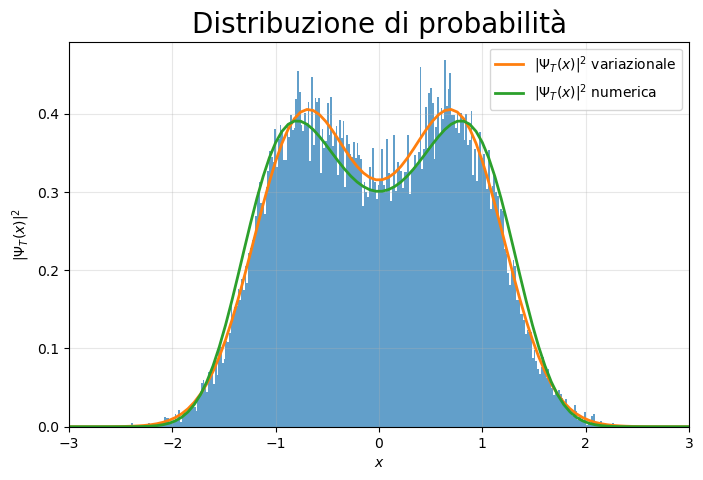

In [6]:
x = np.linspace(-3, 3, 100)

# Probabilità teorica
def f(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2)) + np.exp(-(x+mu)**2/(2*sigma**2))

p_var = f(x, mu[-1], sigma[-1])**2
p_var /= np.trapezoid(p_var, x)          

# Probabilità numerica
def V(x): 
    return x**4 - 2.5*x**2

a = 10
N = 1000
x_num = np.linspace(-a/2, a/2, N)
dx = x_num[1] - x_num[0]
CD = np.diag(np.ones(N-1), -1) - 2*np.diag(np.ones(N), 0) + np.diag(np.ones(N-1), 1)
H = -0.5 * CD / (dx**2) + np.diag(V(x_num)) 
E, psi = np.linalg.eigh(H)
psi = (psi.T) / np.sqrt(dx)   
p_num = np.interp(x, x_num, psi[0]**2)

plt.figure(figsize=(8,5))

pos = np.loadtxt('OUTPUT/position/position.dat', skiprows=1)
plt.hist(pos, 300, density=True, alpha=0.7)
plt.plot(x, p_var, lw=2, label=r'$|\Psi_T(x)|^2$ variazionale')
plt.plot(x, p_num, lw=2, label=r'$|\Psi_T(x)|^2$ numerica')
plt.xlabel('$x$', fontsize=10)
plt.ylabel(r'$|\Psi_T(x)|^2$', fontsize=10)
plt.title('Distribuzione di probabilità', fontsize=20)
plt.xlim(-3, 3)
plt.grid(True, alpha=.3)
plt.legend()

plt.show()
